# Objective: Classifify images in three categories

## Step1: Import All dependencies

In [ ]:
!pip install  -q tensorflow
!pip install  -q  gradio

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.15.0


## Step 2: Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/Deep Learning Project /4. Image Classification Using CNN")

In [5]:
# Extract dataset.rar file (Run only First Time)
# !pip install patool
# import patoolib
# patoolib.extract_archive("dataset.rar")
# patoolib.extract_archive("test_examples.rar")

In [6]:
!dir

dataset      FINAL_CNN.html				       test_examples
dataset.rar  Multi_Class_Image_Classification_Using_CNN.ipynb  test_examples.rar


## Step 3: Build CNN Model

In [7]:
# create CNN model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):

        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(150, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(200, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # ------------------------ANN-----------------------
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(2000))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


## Step 4: Data Reading

In [8]:
DATASET = "dataset"  # this folde must contain three subfolder with images
MODEL = "Scene.model" # name to store the model on disk
PLOT = "plot.png" # plot name

In [9]:
# initialize the data and labels
print("[INFO] loading images...")
data = []  # x
labels = [] # y

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar:
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Buildings":
            label = 0
        elif label == "Forest":
            label = 1
        elif label == "Sea":
            label = 2
        labels.append(label)
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/1326 [00:00<?, ?it/s]

In [10]:
# check shape of single image
data[0].shape

(28, 28, 3)

In [ ]:
data[0]

## Step 5: Data Spliting

In [12]:
# perform data normalisation
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
data[0]

In [14]:
# Split the data into train test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [15]:
# verify shapes
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(994, 28, 28, 3)
(332, 28, 28, 3)
(994,)
(332,)


In [16]:
trainY[0] # 1

0

In [17]:
# Perform one hot label encoding
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [18]:
trainY[0]

array([1., 0., 0.], dtype=float32)

## Step 6: Data Preprocessing (Augumentation)

In [19]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

## Step 7: Compile and Training

In [25]:

INIT_LR = 1e-3
BS = 64

# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(learning_rate=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [26]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 50)        3800      
                                                                 
 activation_5 (Activation)   (None, 28, 28, 50)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 50)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 150)       187650    
                                                                 
 activation_6 (Activation)   (None, 14, 14, 150)       0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 150)         0         
 g2D)                                                 

In [27]:
# train the network

EPOCH  = 100
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCH,
              verbose=1)


# save the model and label binarizer to disk
print("[INFO] serializing network ...")
model.save("cnn_model_{}.h5".format(EPOCH))

[INFO] training network...
Epoch 1/100
15/15 [==============================] - 3s 62ms/step - loss: 0.9964 - accuracy: 0.5269 - val_loss: 0.7546 - val_accuracy: 0.5934
Epoch 2/100
15/15 [==============================] - 1s 34ms/step - loss: 0.7656 - accuracy: 0.6731 - val_loss: 0.8029 - val_accuracy: 0.6265
Epoch 3/100
15/15 [==============================] - 1s 34ms/step - loss: 0.7184 - accuracy: 0.6774 - val_loss: 0.5928 - val_accuracy: 0.7500
Epoch 4/100
15/15 [==============================] - 0s 32ms/step - loss: 0.6034 - accuracy: 0.7344 - val_loss: 0.4750 - val_accuracy: 0.8042
Epoch 5/100
15/15 [==============================] - 0s 32ms/step - loss: 0.5006 - accuracy: 0.8065 - val_loss: 0.4676 - val_accuracy: 0.8133
Epoch 6/100
15/15 [==============================] - 0s 31ms/step - loss: 0.4636 - accuracy: 0.8140 - val_loss: 0.5453 - val_accuracy: 0.7771
Epoch 7/100
15/15 [==============================] - 0s 32ms/step - loss: 0.4788 - accuracy: 0.8022 - val_loss: 0.4748 - 

## Step 8:  Model Evaluation

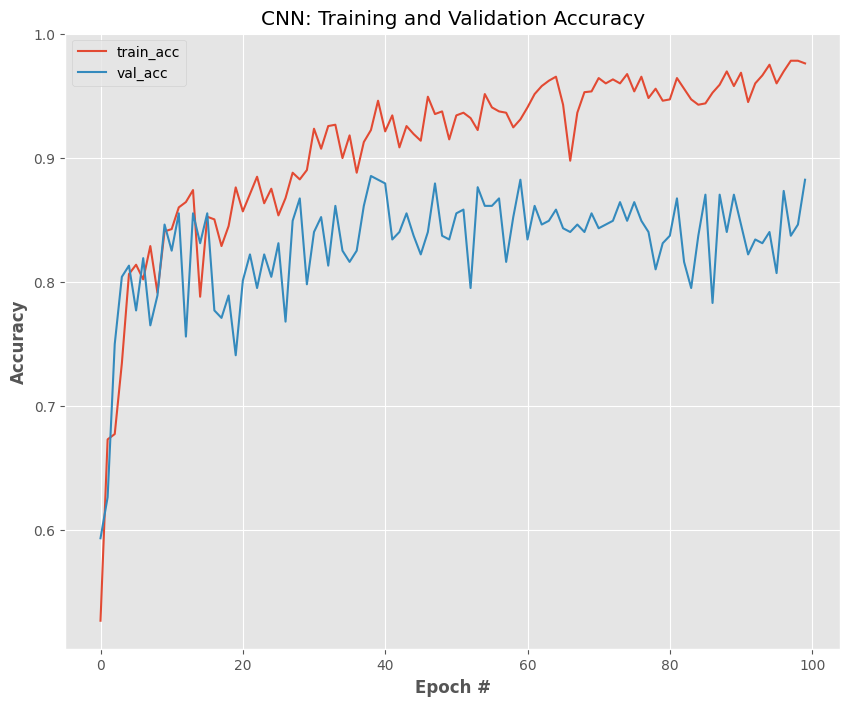

In [28]:
# plot the training and validation accuracy  https://justpaste.it/ed3e5
N = np.arange(0, EPOCH )
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

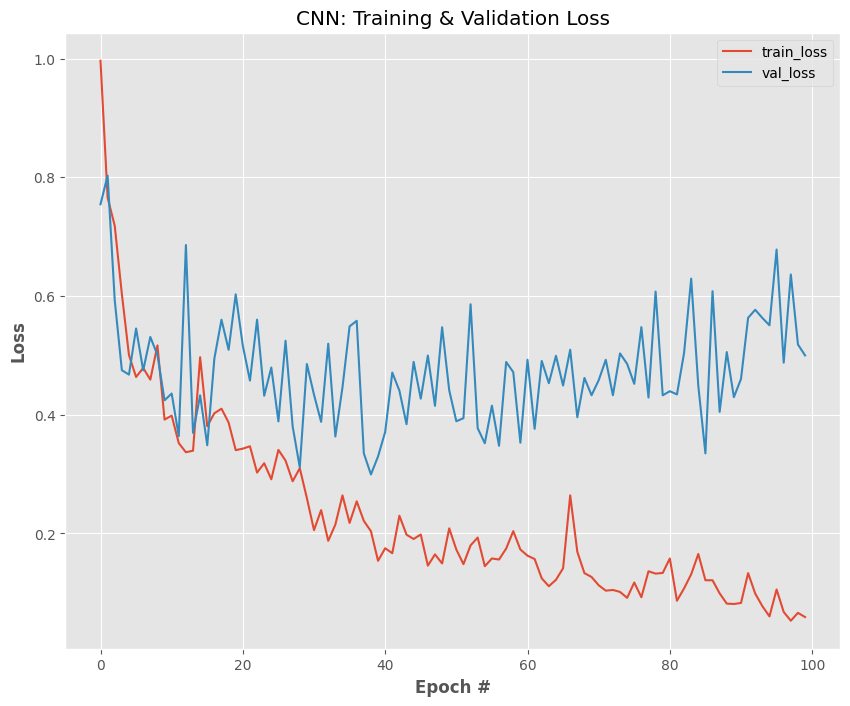

In [29]:
# plot the training and validation loss
N = np.arange(0, EPOCH)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

### Confusion Matrix (Homework)

## Step 9: Prediction on Unseen Data

In [30]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)

import imutils

In [31]:
# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["Buildings", "Forest", "Sea"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


## Step 10: Deployment on Gradio

In [32]:
import gradio as gr
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

ModuleNotFoundError: No module named 'gradio'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Deep Learning Projects/2. Image Classification using CNN")

# # load the model
print("[INFO] loading network and...")
model = load_model("cnn_model_{}.h5".format(50))

In [ ]:
def predict_image(image):
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    result = dict()
    result["Buildings"] = round(float(list(preds)[0]), 3)
    result["Forest"] = round(float(list(preds)[1]), 3)
    result["Sea"] = round(float(list(preds)[2]), 3)

    print(result)
    return result

In [ ]:
im = gr.Image()
label = gr.Label(num_top_classes=3)
gr.Interface(fn=predict_image, inputs=im, outputs=label, title="CNN Demo").launch(share=True, debug=True)

## The End


